# ADA 2018 - Homework 3



## Undestanding the StackOverflow community


Deadline: Nov 7th 2018, 23:59:59

Submission link: Check channel homework-3-public

StackOverflow is the most popular programming-related Q&A website. It serves as a platform for users to ask and answer questions and to vote questions and answers up or down. Users of StackOverflow can earn reputation points and "badges"; for example, a person is awarded 10 reputation points for receiving an "up" vote on an answer given to a question, and 5 points for the "up" vote on a question asked. Also, users receive badges for their valued contributions, which represents a kind of gamification of the traditional Q&A site. 

[Learn more about StackOverflow on Wikipedia](https://en.wikipedia.org/wiki/Stack_Overflow)

----

Dataset link:

https://drive.google.com/open?id=1POlGjqzw9v_pZ_bUnXGihOgk45kbvNjB

http://iccluster053.iccluster.epfl.ch/Posts.json.zip (mirror 1)

https://iloveadatas.com/datasets/Posts.json.zip (mirror 2)

Dataset description:

* **Id**: Id of the post
* **CreationDate**: Creation date of the post (String format)
* **PostTypeId**: Type of post (Question = 1, Answer = 2)
* **ParentId**: The id of the question. Only present if PostTypeId = 2
* **Score**: Points assigned by the users
* **Tags**: Tags of the question. Only present if PostTypeId = 1
* **Title**: Only present if PostTypeId = 1
* **ViewCount**: Only present if PostTypeId = 1

The dataset format is JSON. Here are examples of a question and an answer:

Question:
```json
{
    "Id": 10130734,
    "CreationDate": "2012-04-12T19:51:25.793+02:00",
    "PostTypeId": 1,
    "Score": 4,
    "Tags": "<python><pandas>",
    "Title": "Best way to insert a new value",
    "ViewCount": 3803
}
```

Answer:
```json
{  
   "CreationDate":"2010-10-26T03:19:05.063+02:00",
   "Id":4020440,
   "ParentId":4020214,
   "PostTypeId":2,
   "Score":1
}
```

----
Useful resources:

**Spark SQL, DataFrames and Datasets Guide**

https://spark.apache.org/docs/latest/sql-programming-guide.html

**Database schema documentation for the public data dump**

https://meta.stackexchange.com/questions/2677/database-schema-documentation-for-the-public-data-dump-and-sede

----

**Note:** Use Spark where possible. Some computations can take more than 10 minutes on a common notebook. Consider to save partial results on disk.

In [1]:
import pandas as pd
import numpy as np

import platform

#In our team, Windows user need findspark. For Mac findspark can cause problem
if platform.system() == 'Windows':
    import findspark
    findspark.init()

from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark.sql import SparkSession
from pyspark import SparkContext, SparkFiles

from scipy.stats import mannwhitneyu

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

DATA_FOLDER = 'data/'

### Task A: Convert the dataset to a more convenient format
As a warm-up task (and to avoid to warm up your laptop too much), load the dataset into a Spark dataframe, show the content, and save it in the _Parquet_ format. Use this step to convert the fields to a more convenient form.

Answer the following questions:

1. How many questions have been asked on StackOverflow?
2. How many answers have been given?
3. What is the percentage of questions with a score of 0?

**Hint:** The next tasks involve a time difference. Consider storing time in numeric format.

**Hint:** Load the dataset from the Parquet file for the next tasks.

In [2]:
# To run only once
data_stack = spark.read.json(DATA_FOLDER + 'Posts.json')
data_stack.write.parquet("data_stack.parquet")

In [2]:
data_stack = spark.read.parquet("data_stack.parquet")

# Convert CreationDate into timestamp
data_stack = data_stack.withColumn("CreationDate", to_timestamp(data_stack['CreationDate'], "yyyy-MM-dd'T'kk:mm:ss.SSSXXX"))

data_stack_rdd = data_stack.rdd

In [3]:
# Determine the structure of the data
data_stack.printSchema()

root
 |-- CreationDate: timestamp (nullable = true)
 |-- Id: long (nullable = true)
 |-- ParentId: long (nullable = true)
 |-- PostTypeId: long (nullable = true)
 |-- Score: long (nullable = true)
 |-- Tags: string (nullable = true)
 |-- Title: string (nullable = true)
 |-- ViewCount: long (nullable = true)



In [4]:
data_stack.show(5)

+-------------------+--------+--------+----------+-----+--------------------+--------------------+---------+
|       CreationDate|      Id|ParentId|PostTypeId|Score|                Tags|               Title|ViewCount|
+-------------------+--------+--------+----------+-----+--------------------+--------------------+---------+
|2017-08-17 16:20:17|45740344|45740224|         2|    0|                null|                null|     null|
|2017-08-17 16:20:25|45740346|45739185|         2|    1|                null|                null|     null|
|2017-08-17 16:20:28|45740348|    null|         1|    2|<flash><react-nat...|Is it possible to...|      143|
|2017-08-17 16:20:36|45740350|45739102|         2|    1|                null|                null|     null|
|2017-08-17 16:20:46|45740352|42473616|         2|    0|                null|                null|     null|
+-------------------+--------+--------+----------+-----+--------------------+--------------------+---------+
only showing top 5 

We load the dataset and save it as a parquet file as recommended and to use the advantages of the architecture of Spark. We already convert CreationDate to a timestamp that we can use easier for the next tasks. We see that all the columns are in format that correspond to the schema. We don't need to transform an other one. 

In [3]:
# Compute the number of question
number__of_question = data_stack_rdd.filter(lambda x : x.PostTypeId == 1).count()
print("The number of question in StackOverflow : {}".format(number__of_question))

The number of question in StackOverflow : 15647060


In [4]:
# Compute the number of answer
number__of_answer = data_stack_rdd.filter(lambda x : x.PostTypeId == 2).count()
print("The number of answer in StackOverflow : {}".format(number__of_answer))

The number of answer in StackOverflow : 25192772


In [5]:
# Compute the number of question with a null score
number_of_question_score_0 = data_stack_rdd.filter(lambda x : (x.PostTypeId == 1) and (x.Score == 0)).count()
print("The proportion of question with a null score in StackOverflow : {} %"\
      .format(str(number_of_question_score_0 * 100/number__of_question)[:6]))

The proportion of question with a null score in StackOverflow : 46.543 %


We use rdd that allow us to count directly but we could also use the filter function of Spark dataframe and take its length. 

As we can see, each question in StackOverflow has 1.61 answers in average. We didn't look at the proportion of questions without answer but less than half of the questions have a null score. It doesn't mean that these questions receive no answer but it may show that they are less interesting or more trivial for users.  

### Task B: What are the 10 most popular tags?

What are the most popular tags in StackOverflow? Use Spark to extract the information you need, and answer the following questions with Pandas and Matplotlib (or Seaborn):

1. What is the proportion of tags that appear in fewer than 100 questions?
2. Plot the distribution of the tag counts using an appropriate representation.
3. Plot a bar chart with the number of questions for the 10 most popular tags.

For each task describe your findings briefly.

In [7]:
# From the main data set, extract all tags and gather them in a 1D flatMap
rdd_tags = data_stack_rdd.filter(lambda r: r.Tags != None).flatMap(lambda r: [(x,) for x in (r.Tags[1:-1].split('><'))])

In [8]:
# Count the number of occurence of each tag
df_tags = pd.DataFrame.from_dict(rdd_tags.countByKey(), orient='index')\
            .rename(index=str, columns={0: "count"}).sort_values('count',ascending=False)
df_tags.head(5)

,count
javascript,1585495
java,1352735
c#,1172492
php,1136082
android,1088811


In [9]:
# Compute the proportion of tags appearing in fewer than 100 questions
total_tags = len(df_tags)
df_tags_less_100 = df_tags[df_tags['count'] < 100]
total_tags_less_100 = len(df_tags_less_100)
print('Proportion of tags appearing in fewer than 100 questions : {} %'.
      format(str(total_tags_less_100*100/total_tags)[:5]))

Proportion of tags appearing in fewer than 100 questions : 67.97 %


We split all the tags that appear in the questions and count by tags before to create a Pandas DataFrame that we are more comfortable with.

Most tags appear in less than 100 questions. This seems quite logic, as a wide part of the users are using mainstream programs and libraries, while most specialized tools are used by only a small community.

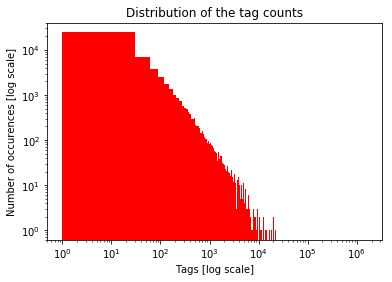

In [10]:
# Plot the number of occurences of tags, in a log-log plot
plt.hist(df_tags.values, len(df_tags), log = True, color = 'r');
plt.xscale('log')

plt.title('Distribution of the tag counts');
plt.xlabel('Tags [log scale]');
plt.ylabel('Number of occurences [log scale]');

Once again, we see very clearly that less than 1000 tags (= tools) are used by tens of thousands of users, while the most part are only used by a small number of specialists.

We see by using a log-log plot that the distribution of tags represent a power law because we see clearly the straight line. It confirms the first percentage during this task that a large number of tags apear less than 100 times.  

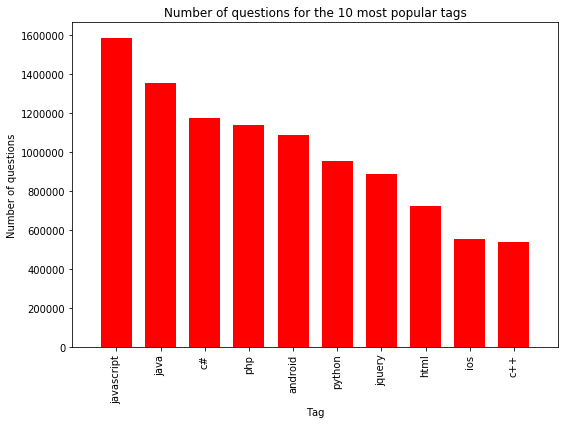

In [11]:
# Plot the number of questions related to the 10 most popular tags
y = df_tags['count'].values[:10]
x = df_tags.index.values[:10]

fig, ax = plt.subplots(figsize=(8, 6))
index = range(len(y))
bar_width = 0.7

ax.bar(index, y, bar_width, color='r')

ax.set_xlabel('Tag')
ax.set_ylabel('Number of questions')
ax.set_title('Number of questions for the 10 most popular tags')
ax.set_xticks(index)
plt.xticks(rotation=90)
ax.set_xticklabels(x)
ax.set_xlim(-1, len(x))
fig.tight_layout()
plt.show()

Once again, no surprise here, the most widespread tools are also the ones who prompt the more questions, above hundreds of thousands of use.

### Task C: View-score relation

We want to investigate the correlation between the view count and the score of questions.

1. Get the view count and score of the questions with tag ```random-effects``` and visualize the relation between these two variables using an appropriate plot.
2. Are these two variables correlated? Use the Pearson coefficient to validate your hypothesis. Discuss your findings in detail.

**Hint:** Inspect the data visually before drawing your conclusions.

First, we select the ViewCount and Score columns with tag `random-effects` with SparkSQL. Then we convert to Pandas in order to use the statistical functions of the library. We do not loose any advantage of the distributed computation of Spark by going to Pandas as the selected data has only 100 elements.

In [5]:
# Creation of the template to be able to use SQL
data_stack.registerTempTable('data_stack')

In [13]:
query_rndeff = """
select ViewCount, Score from data_stack
where Tags like '%<random-effects>%' 
"""

rndeff_tag = spark.sql(query_rndeff)

df_rndeff = rndeff_tag.toPandas()

In [14]:
df_rndeff.describe(percentiles=[.25, .5, .75, .90])

,ViewCount,Score
count,100.000000,100.000000
mean,1191.830000,1.500000
std,5037.166977,4.154832
min,10.000000,-2.000000
25%,64.250000,0.000000
50%,179.000000,0.000000
75%,534.000000,1.000000
90%,975.700000,3.100000
max,42678.000000,31.000000


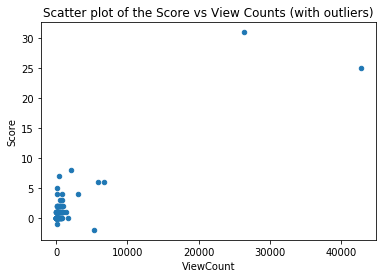

In [17]:
df_rndeff.plot.scatter(x='ViewCount', y='Score');
plt.title('Scatter plot of the Score vs View Counts (with outliers)');

In [18]:
df_rndeff.corr(method='pearson')

,ViewCount,Score
ViewCount,1.000000,0.882197
Score,0.882197,1.000000


The describe table shows that the values of both Score and ViewCount are compact until the 90% quantile and gains one order of magnitude at the max values. This is a sign of the presence of outliers. The scatterplot confirms this observation. We can consider that there are 2 outliers, the remaining data being quite regrouped.

The Pearson correlation is high (0.88) but as the Pearson method is not robust against outliers, this correlation is inconclusive. We have to remove the 2 outliers in order to have a better estimation of the correlation or by using a Spearman correlation.

In [19]:
# Remove outliers
df_rndeff_nooutliers = df_rndeff.loc[df_rndeff.Score <= 10, :]

In [20]:
df_rndeff_nooutliers.describe(percentiles=[.25, .5, .75, .90])

,ViewCount,Score
count,98.000000,98.000000
mean,511.897959,0.959184
std,1080.012700,1.630371
min,10.000000,-2.000000
25%,62.750000,0.000000
50%,169.000000,0.000000
75%,495.000000,1.000000
90%,855.300000,2.300000
max,6699.000000,8.000000


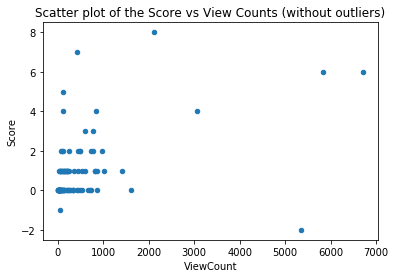

In [21]:
df_rndeff_nooutliers.plot.scatter(x='ViewCount', y='Score');
plt.title('Scatter plot of the Score vs View Counts (without outliers)');

In [22]:
df_rndeff_nooutliers.corr(method='pearson')

,ViewCount,Score
ViewCount,1.000000,0.439389
Score,0.439389,1.000000


After removing the 2 outliers, we can compute once again the Pearson correlation. This time, the result is much lower (0.44). It has been divided by a factor 2 !

We can conclude that there is no strong correlation between ViewCount and Score. Some knowledge about StackOverflow helps the analysis. A high score means that a discussion thread contains useful answers about a problem, whereas the view count reflects how common is a problem. Obviously, if a thread is about a frequent problem and provides quality answers, both the view count and the score will be high. As the users search for discussion threads with keywords through search engines and not with score rankings, the view count is not really correlated with the score.

### Task D: What are the tags with the fastest first answer?

What are the tags that have the fastest response time from the community? We define the response time as the difference in seconds between the timestamps of the question and of the first answer received.

1. Get the response time for the first answer of the questions with the tags ```python``` and ```java```.
2. Plot the two distributions in an appropriate format. What do you observe? Describe your findings and discuss the following distribution properties: mean, median, standard deviation.
3. We believe that the response time is lower for questions related to Python (compare to Java). Contradict or confirm this assumption by estimating the proper statistic with bootstrapping. Visualize the 95% confidence intervals with box plots and describe your findings.
3. Repeat the first analysis (D1) by using the proper statistic to measure the response time for the tags that appear at least 5000 times. Plot the distribution of the 10 tags with the fastest response time.


In [6]:
# Search for every question that has <python> as one of its tags
query_python_question = """
select * from data_stack
where Tags like '%<python>%' and CreationDate is not null
"""
python_question_data = spark.sql(query_python_question)
python_question_data.registerTempTable('python_question')

In [7]:
# Search for every question that has <java> as one of its tags
query_java_question = """
select * from data_stack
where Tags like '%<java>%' and CreationDate is not null
"""
java_question_data = spark.sql(query_java_question)
java_question_data.registerTempTable('java_question')

In [8]:
# DataFrame of the first answer for each question
answer_min = """
select MIN(CreationDate) as First_answer, ParentId 
from (select CreationDate, ParentId from data_stack
      where PostTypeId = 2 and CreationDate is not null)
group by ParentId
"""
answer_min_data = spark.sql(answer_min)
answer_min_data.registerTempTable('answer_min')

In [9]:
# Join question with <python> and its first answer
python_first_answer = """
select CreationDate, Tags, First_answer
from python_question
inner join answer_min on python_question.Id = answer_min.ParentId
"""
python_first_answer_data = spark.sql(python_first_answer)

forma = 'yyyy-MM-dd HH:mm:ss.000'
python_first_answer_data = python_first_answer_data.withColumn("Time_diff",\
                    (unix_timestamp(python_first_answer_data.First_answer, format = forma) -\
                     unix_timestamp(python_first_answer_data.CreationDate, format = forma)))

python_first_answer_data.registerTempTable('python_answer')

# Take only the 'human' possible time difference
python_answer_filter = """
select * from python_answer
where Time_diff > 0
"""

python_time = spark.sql(python_answer_filter).toPandas()

python_time.head(5)

,CreationDate,Tags,First_answer,Time_diff
0,2008-09-02 09:40:26,<python><distutils>,2008-09-02 11:43:45,7399
1,2008-09-18 13:41:22,<python><api><sockets><ssl><gmail>,2008-09-18 15:06:11,5089
2,2008-09-22 17:08:12,<python><ms-word><openxml><docx>,2008-09-22 17:16:43,511
3,2008-10-08 06:34:21,<python><dll><py2exe>,2008-10-08 06:46:57,756
4,2008-10-22 23:38:30,<python><module>,2008-10-22 23:40:26,116


In [10]:
# Join question with <java> and its first answer
java_first_answer = """
select CreationDate, Tags, First_answer
from java_question
inner join answer_min on java_question.Id = answer_min.ParentId
"""
java_first_answer_data = spark.sql(java_first_answer)

forma = 'yyyy-MM-dd HH:mm:ss.000'
java_first_answer_data = java_first_answer_data.withColumn("Time_diff",\
                    (unix_timestamp(java_first_answer_data.First_answer, format = forma) -\
                     unix_timestamp(java_first_answer_data.CreationDate, format = forma)))

java_first_answer_data.registerTempTable('java_answer')

# Take only the 'human' possible time difference
java_answer_filter = """
select * from java_answer
where Time_diff > 0
"""
java_time = spark.sql(java_answer_filter).toPandas()

java_time.head(5)

,CreationDate,Tags,First_answer,Time_diff
0,2008-08-27 15:21:31,<java><cluster-computing><terracotta><jgroups>,2008-08-27 15:53:33,1922
1,2008-09-11 02:40:12,<java><java-io>,2008-09-11 02:45:02,290
2,2008-09-17 03:29:03,<java><validation><date><mask>,2008-09-17 03:31:39,156
3,2008-09-25 09:41:11,<java><generics><constraints>,2008-09-25 10:02:09,1258
4,2008-10-10 15:53:53,<java><eclipse><eclipse-3.4><ganymede>,2008-10-10 16:04:59,666


We exctract all the questions that have as tags `<python>` and/or `<java>` by using SQL. SQL allows us to keep the code clean and convert the Spark dataframe to Pandas dataframe at the very end. We tried to use SQL to compute the time difference but it comes with errors. We keep only the 'human' possible time difference. The negative time difference can be due to a bug or that a question was removed but the answer was kept into the database and the Id of the question was reused. We don't keep 0 as well as a correct value because it's not very human to be so fast and like this we can use log-log without artefact. Note that all time differences are calculated at the second scale, wich means that time differences of 0s could be at the order of milliseconds and the answer might have been generated by a bot.

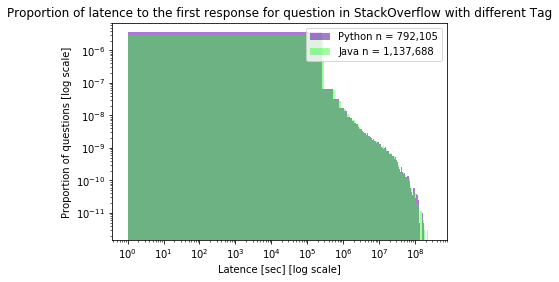

In [11]:
plt.hist(python_time.Time_diff, 1000, alpha=0.5, log = True, density = True,
         label="Python n = {:,}".format(len(python_time)), color = "#4B0092")
plt.hist(java_time.Time_diff, 1000, alpha=0.4, log =True, density = True,
         label='Java n = {:,}'.format(len(java_time)), color = "#1AFF1A")
plt.xscale('log')
plt.legend(loc='upper right')
plt.title("Proportion of latence to the first response for question in StackOverflow with different Tag")
plt.xlabel("Latence [sec] [log scale]")
plt.ylabel("Proportion of questions [log scale]")
plt.show()

As we can see, the two distribution of time response between `<python>` and `<java>` tags are the same. The only difference is the number of times the corresponding tag appears. We also see with this log-log histogram that these distributions do not follow exactly a power law. Only from around 10^6 to 10^7 seconds appear a straight slope. We see that the distribution is more or less uniform to 10^5 seconds but the first answer can also appear after more than 3 years.

In [14]:
def Bootstrap(Data_Frame, frac, N, CI):
    if CI < 0 or CI > 100:
        CI = 95
    Median = []
    for time in range(N):
        Sample = np.log10(Data_Frame.sample(frac= frac, replace = True).Time_diff.values)
        Median.append(np.median(Sample))
    return (np.percentile(Median, (100 - CI)/2), np.percentile(Median, 100 - (100 - CI)/2))

We do a bootstrap where we take 80% of the original dataset (with replacement) 30 times according to <a href ="https://machinelearningmastery.com/a-gentle-introduction-to-the-bootstrap-method/">here</a>. If we do more times (10k as recommanded normally) it does not improve the interval because even after 30 times, the 95% confidence interval is already really narrow for both tag. 

In [16]:
# Log10 transformation of the data
Data = [np.log10(python_time.Time_diff), np.log10(java_time.Time_diff)]
CI = [Bootstrap(python_time, 0.8, 30, 95), Bootstrap(java_time, 0.8, 30, 95)]

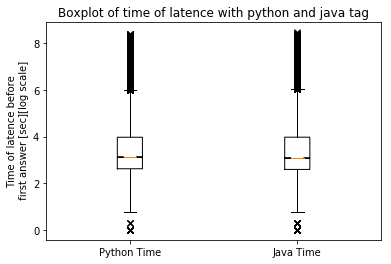

In [36]:
fig, ax = plt.subplots()
plt.boxplot(Data, notch = True, conf_intervals = CI, flierprops= dict(markerfacecolor='b', marker='x'))
ax.set_xticklabels(['Python Time', 'Java Time']);
plt.ylabel('Time of latence before\n first answer [sec][log scale]');
plt.title("Boxplot of time of latence with python and java tag");

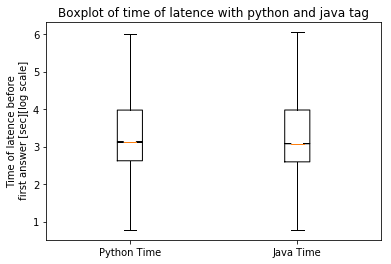

In [37]:
fig, ax = plt.subplots()
plt.boxplot(Data, notch = True, conf_intervals = CI, showfliers= False)
ax.set_xticklabels(['Python Time', 'Java Time']);
plt.ylabel('Time of latence before\n first answer [sec][log scale]');
plt.title("Boxplot of time of latence with python and java tag");

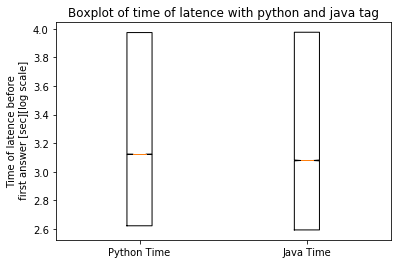

In [38]:
fig, ax = plt.subplots()
plt.boxplot(Data, notch = True, conf_intervals = CI, showfliers= False, whis = 0, showcaps = False)
ax.set_xticklabels(['Python Time', 'Java Time']);
plt.ylabel('Time of latence before\n first answer [sec][log scale]');
plt.title("Boxplot of time of latence with python and java tag");

We decide to perform different representations of the boxplot and look them as a zoom to see the difference between the two tags. We do not put y scale in a logscale when we plot the graph because it can have some artefacts according to <a href = "https://www.stata.com/support/faqs/graphics/box-plots-and-logarithmic-scales/">here</a>.

In [11]:
statistical_test = mannwhitneyu(python_time.Time_diff, java_time.Time_diff, alternative='less')
print("The pvalue of Mann-Witney test for the test that reponse from <python> is lower than for <java> : {}"\
     .format(statistical_test.pvalue))

The pvalue of Mann-Witney test for the test that reponse from <python> is lower than for <java> : 1.0


In [17]:
statistical_test = mannwhitneyu(python_time.Time_diff, java_time.Time_diff, alternative='greater')
effect_size = 1 - (2*statistical_test.statistic / (len(python_time) * len(java_time)))
print("The pvalue of Mann-Witney test for the test that reponse from <python> is greater than for <java> : {}"\
     .format(statistical_test.pvalue))
print("The effect size is : {}".format(effect_size))

The pvalue of Mann-Witney test for the test that reponse from <python> is greater than for <java> : 1.7382666702474318e-83
The effect size is : -0.016325043606010947


We see with the boxplot that the two response times are quite the same. The two distributions have a big overlap inside the quantiles of the boxplot and the median are also quite the same. The bootstrapping tell us that the confidence interval of the median is really close to it. 

We perform a Mann-Witney U test to test if `<python>` response times are lower than for `<java>`. Indeed it is the more apropriate statistical test. We have two sample that do not come from a normal distribution and the are not paired (see lesson 5 of ADA slide 52). As the pvalue is 1, we cannot say that the question with python tag have a answer quicker than the ones with java tag. If we perform the test for `<python>` response times greater than for `<java>`, the statistical test is significant. The effect size is very small, therefore, the effect is very weak. It makes no sense to declare that `<java>`reponse times are lower than those of `<python>` because the effect is so weak, the number of samples so great and the overlap is almost complete. 

In [22]:
# Take each question with its first answer
question_query = """
select * 
from data_stack
where PostTypeId = 1 and CreationDate is not null
"""

question_data = spark.sql(question_query)
question_data.registerTempTable('question')

Tags_response_time = """
select CreationDate, Tags, First_answer
from question
inner join answer_min on question.Id = answer_min.ParentId
"""
Tags_time_data = spark.sql(Tags_response_time)


In [23]:
forma = 'yyyy-MM-dd HH:mm:ss.000'

Tags_time_data = Tags_time_data.withColumn("Time_diff",\
                    (unix_timestamp(Tags_time_data.First_answer, format = forma) -\
                     unix_timestamp(Tags_time_data.CreationDate, format = forma)))

Tags_time_data.registerTempTable('Tags_time_data')

Tags_time_data_filter = """
select * from Tags_time_data
where Time_diff > 0
"""
Tags_time_data = spark.sql(Tags_time_data_filter)

Tags_time = Tags_time_data.rdd.flatMap(lambda r: [(x,r.Time_diff) for x in (r.Tags[1:-1].split('><'))]).groupByKey()\
                    .map(lambda x : (x[0], list(x[1]))).collect()

We join the question with its first answer before to compute as we did before the time difference. We create a list of tuple with the tag and a list of the entire corresponding time of latence before the first answer. 

In [26]:
def Clear_Tags_time(Tags_time):
    Result = []
    for Tag, time_list in Tags_time:
        if len(time_list) >= 5000:
            median_value = np.median(time_list)
            Result.append((Tag, time_list, median_value))
    return Result

To compute the median of the time reponse for only the tags that appear at least 5'000 times, we create a function to do it in a cleaner way.

In [27]:
# Compute the median and take the 10 first with the smaller median of the time difference between the question
# and its first answer
Result_Tag = Clear_Tags_time(Tags_time)
Result_Tag_data = pd.DataFrame(Result_Tag, columns = ["Tags", "Time_diff_list", "Median"])
Result_Tag_data.set_index("Tags", inplace = True)
Result_Tag_data.drop(["Time_diff_list"], axis =1, inplace = True)
Result_Tag_data.sort_values("Median", ascending = True, inplace = True)
Result_Tag_data_top_10 = Result_Tag_data.head(10)

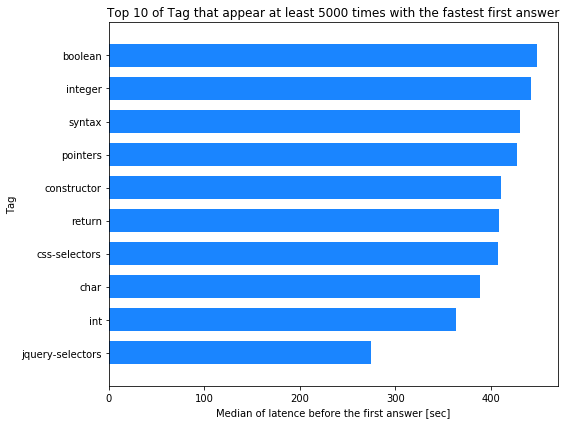

In [29]:
y = Result_Tag_data['Median'].values[:10]
x = Result_Tag_data.index.values[:10]

fig, ax = plt.subplots(figsize=(8, 6))
index = range(len(y))
bar_width = 0.7

ax.barh(index, y, bar_width, color='#1A85FF')

ax.set_ylabel('Tag')
ax.set_xlabel('Median of latence before the first answer [sec]')
ax.set_title('Top 10 of Tag that appear at least 5000 times with the fastest first answer')
ax.set_yticks(index)
plt.yticks()
ax.set_yticklabels(x)
ax.set_ylim(-1, len(x))
fig.tight_layout()
plt.show()

As we can see, these tags have a large difference between their median of latence before the first answer (around 5 min) compare with java or python (around 20 minutes). We also see that these tags are more general so we can easily understand why they often appear and why also their first answer is fast. Indeed, with a general concept, some users can help you even if they do not code with your programming language.

### Task E: What's up with PySpark?
The number of questions asked regarding a specific topic reflect the public’s interest on it. We are interested on the popularity of PySpark. Compute and plot the number of questions with the ```pyspark``` tag for 30-day time intervals. Do you notice any trend over time? Is there any correlation between time and number of questions?


#### Plotting the number of questions with the `pyspark` tag for 30-day time intervals

In [18]:
# Select all questions about pyspark
query_pyspark_question = """
select CreationDate from data_stack
where Tags like '%<pyspark>%' and CreationDate is not null
"""
pyspark_question_data = spark.sql(query_pyspark_question)
pyspark_question_data.registerTempTable('pyspark_question')

In [19]:
# Transform the dataframe to Pandas and set the Date as type datetime64
df_pyspark_time = pyspark_question_data.toPandas().rename(index=int, columns={'CreationDate' : 'Count'})
df_pyspark_time.Count = df_pyspark_time.Count.astype('datetime64')

In [20]:
# Compute the number of questions about pyspark each day
df_pyspark_date = pd.DataFrame(df_pyspark_time['Count'].dt.date.value_counts())
df_pyspark_date.reset_index(inplace=True)
df_pyspark_date = df_pyspark_date.rename(index=int, columns={'index' : 'Date'}).sort_values('Date',ascending=True)
df_pyspark_date.Date = df_pyspark_date.Date.astype('datetime64')

In [21]:
# For all days that do not have any question, between 2014-10-24 and 2018-09-02 (i.e. 47 30-day time spans)
# Create an element with count 0 and include it in the main dataframe
time_range = pd.date_range('2014-10-24', '2018-09-02', freq='1D')
df_time_range = pd.DataFrame({'Date':time_range,'Count':[0]*(len(time_range))})
df_pyspark = pd.merge(df_pyspark_date,df_time_range,how='right',on='Date').sort_values('Date',ascending=True)
df_pyspark.fillna(value=0, inplace = True)
df_pyspark['Count'] = df_pyspark['Count_x'] + df_pyspark['Count_y']
df_pyspark.Count = df_pyspark.Count.astype('int64')
df_pyspark = df_pyspark[['Date','Count']]

# Set the date as index
df_pyspark.set_index(df_pyspark.Date,inplace=True)

In [22]:
# Creating 30-days time intervals
df_pyspark = df_pyspark[['Count']]
list_ = []
for i in range(47):
    list_.append(df_pyspark.Count.iloc[30*i:30*i+30].sum())

In [23]:
df_pyspark_plot = pd.DataFrame.from_dict({'Count': list_})

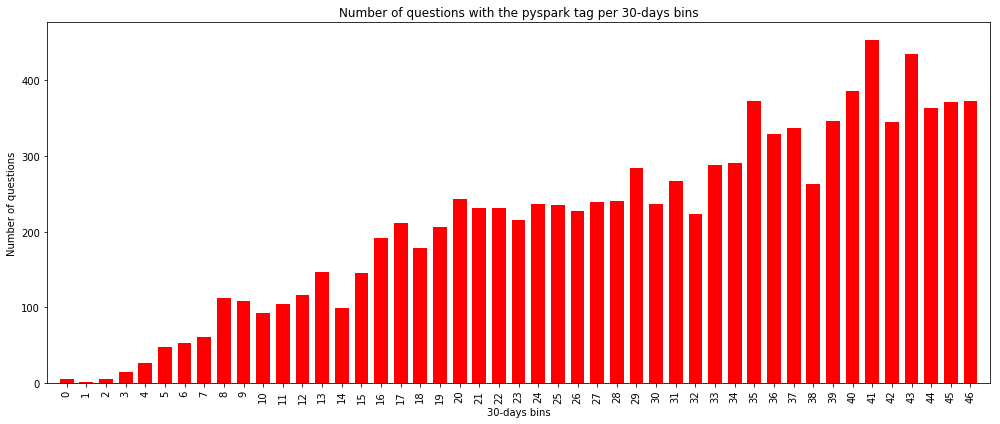

In [44]:
# Plot the number of questions per 30-day time intervals
y = df_pyspark_plot['Count'].values
x = df_pyspark_plot.index.values

fig, ax = plt.subplots(figsize=(14, 6))
index = range(len(y))
bar_width = 0.7

ax.bar(index, y, bar_width, color='r')

ax.set_xlabel('30-days bins')
ax.set_ylabel('Number of questions')
ax.set_title('Number of questions with the pyspark tag per 30-days bins')
ax.set_xticks(index)
plt.xticks(rotation=90)
ax.set_xticklabels(x)
ax.set_xlim(-1, len(x))
fig.tight_layout()
plt.show()

The trend over time is clear. The number of newly asked questions about pyspark is growing in function of the time, in a linear way. Now, we will try to determine if there is any other type of correlation through time.

#### Correlation to hours of the day

In [25]:
# Computing linear correlation
df_pyspark_hour = pd.DataFrame(df_pyspark_time['Count'].dt.hour.value_counts())
df_pyspark_hour.reset_index(inplace=True)
df_pyspark_hour = df_pyspark_hour.rename(index=int, columns={'index' : 'Hour'}).sort_values('Hour',ascending=True)
df_pyspark_hour.corr(method='pearson')

,Hour,Count
Hour,1.000000,0.606141
Count,0.606141,1.000000


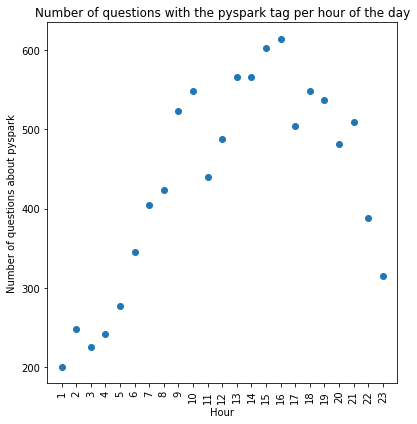

In [47]:
# Plotting in order to be able to detect other kinds of correlation

y, x = df_pyspark_hour.Count, df_pyspark_hour.Hour

fig, ax = plt.subplots(figsize=(6, 6))

ax.scatter(x-1, y)

ax.set_xlabel('Hour')
ax.set_ylabel('Number of questions about pyspark')
ax.set_title('Number of questions with the pyspark tag per hour of the day')
ax.set_xticks(x-1)
plt.xticks(rotation=90)
ax.set_xticklabels(x)
ax.set_xlim(-1, len(x))
fig.tight_layout()
plt.show()

We can clearly see that there is a correlation between hour of the day and pyspark request. However, this correlation is not linear, rather sinusoidal or quadratic-like. This indicate that people asking questions about pyspark are not evenly distributed between time zones around the world. Indeed, certain time zones have a very tiny population of programmers (Pacific) in comparison with others. 

#### Correlation to days of the week

In [65]:
# Computing linear correlation
df_pyspark_dayofweek = pd.DataFrame(df_pyspark_time['Count'].dt.dayofweek.value_counts())
df_pyspark_dayofweek.reset_index(inplace=True)
df_pyspark_dayofweek = df_pyspark_dayofweek.rename(index=int, 
                                                   columns={'index' : 'DayOfWeek'}).sort_values('DayOfWeek',ascending=True)
df_pyspark_dayofweek.corr(method='pearson')

,DayOfWeek,Count
DayOfWeek,1.000000,-0.774521
Count,-0.774521,1.000000


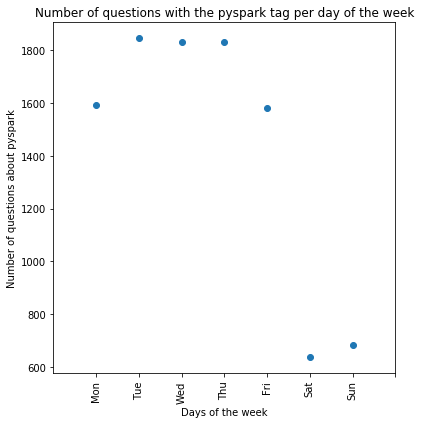

In [66]:
# Plotting in order to be able to detect other kinds of correlation

y, x = df_pyspark_dayofweek.Count, df_pyspark_dayofweek.DayOfWeek

fig, ax = plt.subplots(figsize=(6, 6))

ax.scatter(x, y)

ax.set_xlabel('Days of the week')
ax.set_ylabel('Number of questions about pyspark')
ax.set_title('Number of questions with the pyspark tag per day of the week')
ax.set_xticks(index)
plt.xticks(rotation=90)
ax.set_xticklabels(['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
ax.set_xlim(-1, len(x))
fig.tight_layout()
plt.show()

We can notice very clearly that the number of questions about pyspark asked during weekend is lower in regard with weekdays. There is some kind of step-function-like correlation is this case.

#### Correlation per day of the year

In [67]:
# Computing linear correlation
df_pyspark_dayofyear = pd.DataFrame(df_pyspark_time['Count'].dt.dayofyear.value_counts())
df_pyspark_dayofyear.reset_index(inplace=True)
df_pyspark_dayofyear = df_pyspark_dayofyear.rename(index=int,
                                                   columns={'index' : 'DayOfYear'}).sort_values('DayOfYear',ascending=True)
df_pyspark_dayofyear.corr(method='pearson')

,DayOfYear,Count
DayOfYear,1.000000,-0.182816
Count,-0.182816,1.000000


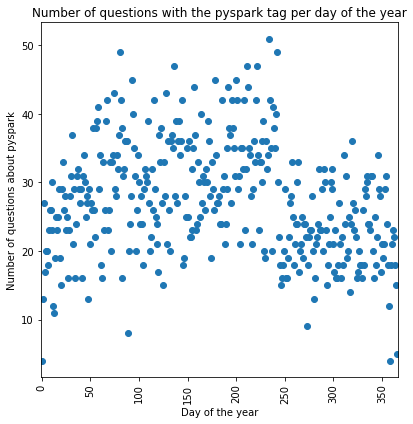

In [68]:
# Plotting in order to be able to detect other kinds of correlation

y, x = df_pyspark_dayofyear.Count, df_pyspark_dayofyear.DayOfYear

fig, ax = plt.subplots(figsize=(6, 6))

ax.scatter(x-1, y)

ax.set_xlabel('Day of the year')
ax.set_ylabel('Number of questions about pyspark')
ax.set_title('Number of questions with the pyspark tag per day of the year')
plt.xticks(rotation=90)
ax.set_xlim(-1, len(x))
fig.tight_layout()
plt.show()

This time correlation seems to be quadratic (-x^2 in this case). However, as the size of the corpus is changing very rapidy (see Overall correlation at the daily scale), and as the number of samples is very low, one cannot conclude. Indeed, this apparent correlation could in fact be caused by the morphologic evolution of the corpus.

#### Overall correlation at the monthly scale

In [27]:
# Select the months and the number of questions about pyspark per month

query_pyspark_group_by = """
SELECT DATE_FORMAT(CreationDate, "Y-MM") as Date, COUNT(DATE_FORMAT(CreationDate, "Y-MM")) as Count
FROM pyspark_question
GROUP BY DATE_FORMAT(CreationDate, "Y-MM")
"""
pyspark_group_by_data = spark.sql(query_pyspark_group_by)
pyspark_group_by_data.registerTempTable('pyspark_group_by')
pyspark_group_by_data.show(3)

+-------+-----+
|   Date|Count|
+-------+-----+
|2017-09|  360|
|2017-10|  355|
|2016-02|  173|
+-------+-----+
only showing top 3 rows



In [28]:
# Create a Pandas dataframe
df_pyspark = pyspark_group_by_data.toPandas().sort_values('Date',ascending=True)

In [29]:
# Create elements with Count=0 when there is no question about pyspark during the month
d = {'Date': ['2014-05', '2014-06', '2014-07', '2014-09'], 'Count': [0, 0, 0, 0]}
df = pd.DataFrame(data=d)

# Last value (2018-12) is probably an aberrant one, so we remove it (iloc[:-1])
df_pyspark = pd.concat([df_pyspark,df]).sort_values('Date',ascending=True).iloc[:-1]

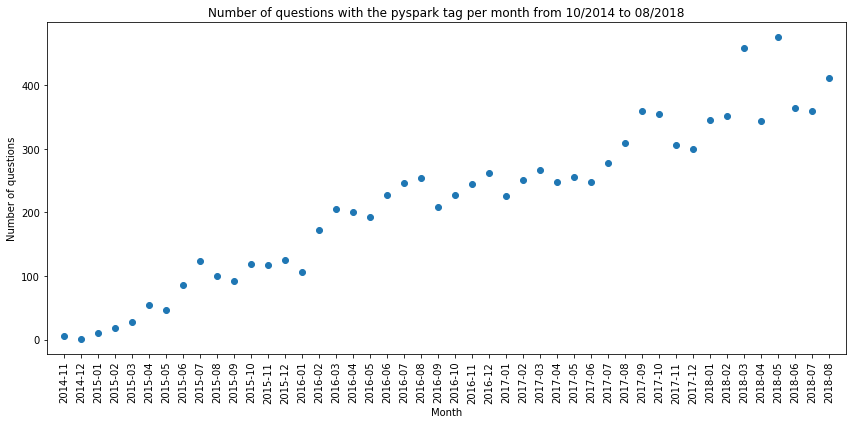

In [73]:
# Plot the scatter plot displaying the number of question about pyspark in function of the months
df_pyspark_corr = df_pyspark.iloc[7:-1]

y, x = df_pyspark_corr.Count, df_pyspark_corr.Date

fig, ax = plt.subplots(figsize=(12, 6))

ax.scatter(x, y)

ax.set_xlabel('Month')
ax.set_ylabel('Number of questions')
ax.set_title('Number of questions with the pyspark tag per month from 10/2014 to 08/2018')
plt.xticks(rotation=90)
ax.set_xlim(-1, len(x))
fig.tight_layout()
plt.show()

This time correlation is the only one which we can argue to be linear. It indicates that the number of question about pyspark grow linearly through time.

In [32]:
df_pyspark['Date'] = range(len(df_pyspark.Date))
df_pyspark.corr(method='pearson')

,Date,Count
Date,1.000000,0.889979
Count,0.889979,1.000000


As a matter of fact, we observe here that the augmentation of question is strongly correlated with the time, in a linear way.